In [1]:
!pip uninstall -y numpy
!pip install numpy==1.26.4 --upgrade --force-reinstall --quiet

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 38.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
import os
os.kill(os.getpid(), 9)

In [1]:
#Install dependencies
!pip install pennylane pennylane-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 14.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset

import math
import re
import random
import pandas as pd
import numpy as np
import time
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
import matplotlib.pyplot as plt
import pennylane as qml
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


In [4]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
domain_neutral_words = {
    "phone", "product", "battery", "headset", "quality", "one", "use"
}
stop_words.update(domain_neutral_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Data Loading and Preprocessing**

In [5]:
with open("/content/drive/MyDrive/QML-Research/Data/sentiment labelled sentences/amazon_cells_labelled.txt", "r") as f:
    lines = f.readlines()

sentences = [line.split("\t")[0] for line in lines]
labels = [int(line.split("\t")[1]) for line in lines]

In [6]:
def clean_and_tokenize(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

cleaned_sents = [clean_and_tokenize(sentence) for sentence in sentences]

# **Padding and Truncation**

In [7]:
max_len = 10
for i in range(len(cleaned_sents)):
  if (len(cleaned_sents[i]) < max_len):
    cleaned_sents[i] += ["<PAD>"] * (max_len - len(cleaned_sents[i]))
  else:
    cleaned_sents[i] = cleaned_sents[i][:max_len]

# **Manual GloVe Embedding**

In [8]:
def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

In [9]:
def sentence_to_vec(sentence, embeddings, dim):
    vectors = []
    for word in sentence:
        if word in embeddings:
            vectors.append(embeddings[word])
        else:
            vectors.append(np.zeros(dim))
    return vectors

In [10]:
def embed_sentences(cleaned_sents, embeddings, dim=5):
    return np.array([sentence_to_vec(tokens, embeddings, dim) for tokens in cleaned_sents])

In [11]:
glove_path = '/content/drive/MyDrive/QML-Research/Data/glove.6B.100d.txt'
glove = load_glove_embeddings(glove_path)

# **PCA**

In [12]:
all_words = list(glove.keys())
all_vectors = np.array([glove[word] for word in all_words])
pca = PCA(n_components=32, random_state=42)
reduced_vectors = pca.fit_transform(all_vectors)
reduced_embeddings = {word: reduced_vectors[i] for i, word in enumerate(all_words)}

# **Word Encoding**

In [13]:
X_embed_np = embed_sentences(cleaned_sents, reduced_embeddings, dim=32)
X_embed = torch.tensor(X_embed_np).float()
y_embed = torch.tensor(labels).float()

# **DataLoader**

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_embed, y_embed, test_size=0.2, random_state=42)

In [15]:
class AmazonDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [16]:
train_dataset = AmazonDataset(X_train, y_train)
train_loader_small = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(AmazonDataset(X_test, y_test), batch_size=1)

# **Quantum Circuit and Model Class**

**Seperate Quantum Circuits for each Gate**

In [17]:
n_qubits = 8
dev_i = qml.device("lightning.qubit", wires=n_qubits, shots=None)
dev_f = qml.device("lightning.qubit", wires=n_qubits, shots=None)
dev_c = qml.device("lightning.qubit", wires=n_qubits, shots=None)
dev_o = qml.device("lightning.qubit", wires=n_qubits, shots=None)

In [18]:
def encode_input(inputs, hidden):
    amp = inputs[:16]
    ang = inputs[16:]
    amp = torch.where(torch.isnan(amp) | torch.isinf(amp), torch.zeros_like(amp), amp)
    amp = amp + torch.randn_like(amp) * 1e-6
    amp = amp / (torch.sqrt(torch.sum(amp**2)) + 1e-8)
    amp_np = amp.detach().cpu().numpy()

    qml.AmplitudeEmbedding(features=amp_np, wires=range(4), normalize=False)
    for i in range(3):
        qml.RY(ang[i], wires=4)
        qml.RZ(ang[i]*0.5, wires=4)
    qml.RY(hidden, wires=7)

@qml.qnode(dev_i, interface="torch")
def input_gate(inputs, hidden, weights):
    encode_input(inputs, hidden)
    for i in range(7): qml.RY(weights[i], wires=i)
    return qml.expval(qml.PauliZ(7))

@qml.qnode(dev_f, interface="torch")
def forget_gate(inputs, hidden, weights):
    encode_input(inputs, hidden)
    for i in range(7): qml.RZ(weights[i], wires=i)
    return qml.expval(qml.PauliZ(7))

@qml.qnode(dev_c, interface="torch")
def cell_gate(inputs, hidden, weights):
    encode_input(inputs, hidden)
    for i in range(7): qml.RY(weights[i], wires=i); qml.RZ(weights[i]*0.3, wires=i)
    return qml.expval(qml.PauliZ(7))

@qml.qnode(dev_o, interface="torch")
def output_gate(inputs, hidden, weights):
    encode_input(inputs, hidden)
    for i in range(7): qml.RY(weights[i]*0.6, wires=i)
    return qml.expval(qml.PauliZ(7))

In [19]:
class QuantumLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Linear(32, 32)
        self.W_i = nn.Parameter(torch.randn(7) * 0.1)
        self.W_f = nn.Parameter(torch.randn(7) * 0.1)
        self.W_c = nn.Parameter(torch.randn(7) * 0.1)
        self.W_o = nn.Parameter(torch.randn(7) * 0.1)
        self.fc = nn.Linear(1, 1)

    def forward(self, x):
        h_t = torch.tensor(0.0, requires_grad=True)
        c_t = torch.tensor(0.0, requires_grad=True)
        for t in range(x.shape[0]):
            x_t = self.embedding(x[t])
            i_t = torch.sigmoid(input_gate(x_t, h_t, self.W_i))
            f_t = torch.sigmoid(forget_gate(x_t, h_t, self.W_f))
            g_t = torch.tanh(cell_gate(x_t, h_t, self.W_c))
            o_t = torch.sigmoid(output_gate(x_t, h_t, self.W_o))
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
        return self.fc(h_t.unsqueeze(0))

In [20]:
model = QuantumLSTM()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCEWithLogitsLoss()

In [21]:
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")

W_i: torch.Size([7])
W_f: torch.Size([7])
W_c: torch.Size([7])
W_o: torch.Size([7])
embedding.weight: torch.Size([32, 32])
embedding.bias: torch.Size([32])
fc.weight: torch.Size([1, 1])
fc.bias: torch.Size([1])


# **Training Loop**

In [22]:
start_time = time.time()
epochs = 50
target_accuracy = 66.0
model.train()

for epoch in range(epochs):
    total_loss = 0
    correct = 0
    total = 0
    epoch_start = time.time()

    for xb, yb in train_loader_small:
        xb = xb.squeeze(0)
        yb = yb.squeeze()

        optimizer.zero_grad()
        output = model(xb)

        output_flat = output.squeeze()
        yb_flat = yb.float()

        loss = loss_fn(output_flat, yb_flat)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = (torch.sigmoid(output_flat) > 0.5).float()
        # prob = custom_probability(output_flat)
        # predicted = (prob > 0.5).float()
        correct += (predicted == yb_flat).sum().item()
        total += 1

    avg_loss = total_loss / len(train_loader_small)
    epoch_time = time.time() - epoch_start
    accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    print(f"Time for epoch: {epoch_time:.2f} seconds")

    if accuracy >= target_accuracy:
        print(f"\nEarly stopping triggered! Target accuracy of {target_accuracy}% reached.")
        print(f"Final accuracy: {accuracy:.2f}%")
        break

total_time = time.time() - start_time
print(f"\nTotal training time: {total_time:.2f} seconds")

Epoch 1, Loss: 0.7002, Accuracy: 49.12%
Time for epoch: 228.82 seconds
Epoch 2, Loss: 0.6957, Accuracy: 50.25%
Time for epoch: 223.49 seconds
Epoch 3, Loss: 0.6953, Accuracy: 48.88%
Time for epoch: 223.54 seconds
Epoch 4, Loss: 0.6926, Accuracy: 52.38%
Time for epoch: 214.51 seconds
Epoch 5, Loss: 0.6973, Accuracy: 47.50%
Time for epoch: 204.59 seconds
Epoch 6, Loss: 0.6952, Accuracy: 49.88%
Time for epoch: 218.08 seconds
Epoch 7, Loss: 0.6960, Accuracy: 49.12%
Time for epoch: 205.29 seconds
Epoch 8, Loss: 0.6971, Accuracy: 48.75%
Time for epoch: 205.95 seconds
Epoch 9, Loss: 0.6918, Accuracy: 53.00%
Time for epoch: 198.62 seconds
Epoch 10, Loss: 0.6970, Accuracy: 51.62%
Time for epoch: 199.91 seconds
Epoch 11, Loss: 0.6962, Accuracy: 48.38%
Time for epoch: 223.72 seconds
Epoch 12, Loss: 0.6948, Accuracy: 50.75%
Time for epoch: 215.98 seconds
Epoch 13, Loss: 0.6961, Accuracy: 49.38%
Time for epoch: 219.53 seconds
Epoch 14, Loss: 0.6960, Accuracy: 50.25%
Time for epoch: 216.77 seconds
E

# **Testing Loop**

=== DETAILED PREDICTION ANALYSIS ===

Sample  1: Logit:  0.131 | Prob: 0.533 | Pred: 1 | Actual: 1 | ✓ CORRECT
Sample  2: Logit:  0.131 | Prob: 0.533 | Pred: 1 | Actual: 1 | ✓ CORRECT
Sample  3: Logit:  0.131 | Prob: 0.533 | Pred: 1 | Actual: 1 | ✓ CORRECT
Sample  4: Logit:  0.131 | Prob: 0.533 | Pred: 1 | Actual: 0 | ✗ WRONG
Sample  5: Logit:  0.131 | Prob: 0.533 | Pred: 1 | Actual: 1 | ✓ CORRECT
Sample  6: Logit:  0.131 | Prob: 0.533 | Pred: 1 | Actual: 1 | ✓ CORRECT
Sample  7: Logit:  0.131 | Prob: 0.533 | Pred: 1 | Actual: 0 | ✗ WRONG
Sample  8: Logit:  0.131 | Prob: 0.533 | Pred: 1 | Actual: 1 | ✓ CORRECT
Sample  9: Logit:  0.131 | Prob: 0.533 | Pred: 1 | Actual: 0 | ✗ WRONG
Sample 10: Logit:  0.131 | Prob: 0.533 | Pred: 1 | Actual: 1 | ✓ CORRECT
Sample 11: Logit:  0.131 | Prob: 0.533 | Pred: 1 | Actual: 1 | ✓ CORRECT
Sample 12: Logit:  0.131 | Prob: 0.533 | Pred: 1 | Actual: 0 | ✗ WRONG
Sample 13: Logit:  0.131 | Prob: 0.533 | Pred: 1 | Actual: 1 | ✓ CORRECT
Sample 14: Logit:  0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


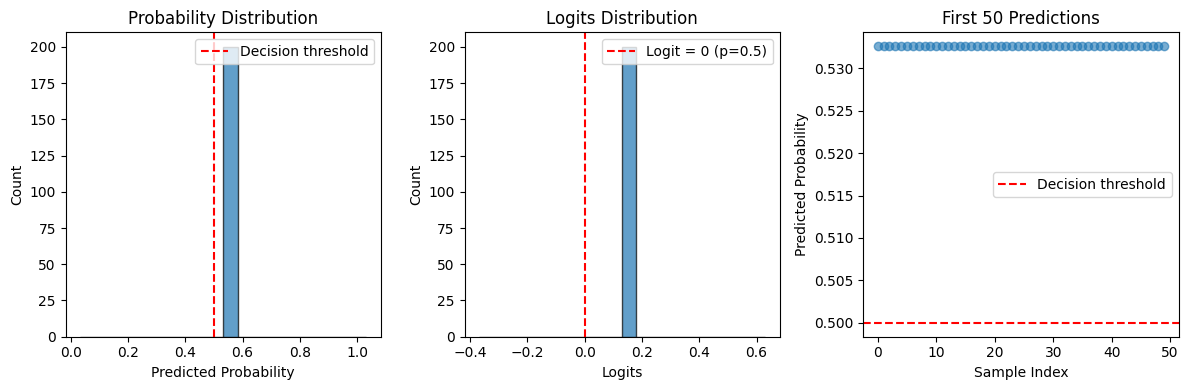

In [23]:
model.eval()
correct = 0
total = 0
predictions = []
actuals = []
logits_list = []
probabilities = []

print("=== DETAILED PREDICTION ANALYSIS ===\n")

with torch.no_grad():
    for i, (xb, yb) in enumerate(test_loader):
        xb = xb.squeeze(0)
        yb = yb.squeeze()

        logits = model(xb)
        logits_flat = logits.squeeze()
        prob = torch.sigmoid(logits_flat)
        pred = (prob > 0.5).float()
        # prob = custom_probability(logits_flat)
        # pred = (prob > 0.5).float()
        actual = yb.float()

        predictions.append(pred.item())
        actuals.append(actual.item())
        logits_list.append(logits_flat.item())
        probabilities.append(prob.item())

        if pred == actual:
            correct += 1
        total += 1

        if i < 20:
            status = "✓ CORRECT" if pred == actual else "✗ WRONG"
            print(f"Sample {i+1:2d}: Logit: {logits_flat.item():6.3f} | "
                  f"Prob: {prob.item():.3f} | Pred: {int(pred.item())} | "
                  f"Actual: {int(actual.item())} | {status}")

print(f"\n=== SUMMARY STATISTICS ===")
print(f"Test Accuracy: {correct / total * 100:.2f}%")
print(f"Total samples: {total}")
print(f"Correct predictions: {correct}")
print(f"Wrong predictions: {total - correct}")

predictions = np.array(predictions)
actuals = np.array(actuals)
probabilities = np.array(probabilities)
logits_list = np.array(logits_list)

print(f"\n=== PREDICTION DISTRIBUTION ===")
pred_0_count = np.sum(predictions == 0)
pred_1_count = np.sum(predictions == 1)
actual_0_count = np.sum(actuals == 0)
actual_1_count = np.sum(actuals == 1)

print(f"Model predicted 0: {pred_0_count} times ({pred_0_count/total*100:.1f}%)")
print(f"Model predicted 1: {pred_1_count} times ({pred_1_count/total*100:.1f}%)")
print(f"Actual 0s in test: {actual_0_count} times ({actual_0_count/total*100:.1f}%)")
print(f"Actual 1s in test: {actual_1_count} times ({actual_1_count/total*100:.1f}%)")

print(f"\n=== BIAS ANALYSIS ===")
if pred_0_count == total:
    print("MODEL IS ALWAYS PREDICTING 0 (NEGATIVE BIAS)")
elif pred_1_count == total:
    print("MODEL IS ALWAYS PREDICTING 1 (POSITIVE BIAS)")
elif pred_0_count > total * 0.9:
    print("MODEL HAS STRONG NEGATIVE BIAS (>90% predicting 0)")
elif pred_1_count > total * 0.9:
    print("MODEL HAS STRONG POSITIVE BIAS (>90% predicting 1)")
else:
    print("MODEL IS PREDICTING BOTH CLASSES")

print(f"\n=== PROBABILITY DISTRIBUTION ===")
print(f"Mean probability: {np.mean(probabilities):.3f}")
print(f"Std probability: {np.std(probabilities):.3f}")
print(f"Min probability: {np.min(probabilities):.3f}")
print(f"Max probability: {np.max(probabilities):.3f}")
print(f"Probabilities near 0.5 (0.4-0.6): {np.sum((probabilities >= 0.4) & (probabilities <= 0.6))}")

print(f"\n=== LOGITS DISTRIBUTION ===")
print(f"Mean logit: {np.mean(logits_list):.3f}")
print(f"Std logit: {np.std(logits_list):.3f}")
print(f"Min logit: {np.min(logits_list):.3f}")
print(f"Max logit: {np.max(logits_list):.3f}")

print(f"\n=== CONFUSION MATRIX ===")
cm = confusion_matrix(actuals, predictions)
print("           Predicted")
print("         0    1")
print(f"Actual 0 {cm[0,0]:3d}  {cm[0,1]:3d}")
print(f"       1 {cm[1,0]:3d}  {cm[1,1]:3d}")

print(f"\n=== CLASSIFICATION REPORT ===")
print(classification_report(actuals, predictions, target_names=['Negative', 'Positive']))

print(f"\n=== MODEL BEHAVIOR DIAGNOSIS ===")
unique_probs = len(np.unique(np.round(probabilities, 3)))
unique_logits = len(np.unique(np.round(logits_list, 3)))

print(f"Unique probability values: {unique_probs}")
print(f"Unique logit values: {unique_logits}")

if unique_probs <= 3:
    print("Very few unique probabilities - model might be stuck!")
elif unique_probs <= 10:
    print("Limited probability diversity - model might have convergence issues")
else:
    print("Good probability diversity")

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(probabilities, bins=20, alpha=0.7, edgecolor='black')
plt.axvline(0.5, color='red', linestyle='--', label='Decision threshold')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.title('Probability Distribution')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(logits_list, bins=20, alpha=0.7, edgecolor='black')
plt.axvline(0, color='red', linestyle='--', label='Logit = 0 (p=0.5)')
plt.xlabel('Logits')
plt.ylabel('Count')
plt.title('Logits Distribution')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(range(min(50, len(probabilities))), probabilities[:50], alpha=0.6)
plt.axhline(0.5, color='red', linestyle='--', label='Decision threshold')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Probability')
plt.title('First 50 Predictions')
plt.legend()

plt.tight_layout()
plt.show()